In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-census-income/adult.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../input/adult-census-income/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
#replacing some special character columns names with proper names 
df.rename(columns={'capital.gain': 'capital gain', 'capital.loss': 'capital loss', 'native.country': 'country','hours.per.week': 'hours per week','marital.status': 'marital','sex':'gender'}, inplace=True)
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital',
       'occupation', 'relationship', 'race', 'gender', 'capital gain',
       'capital loss', 'hours per week', 'country', 'income'],
      dtype='object')

# #Exploring the data set and making it suitable to be trained.


In [5]:
#Checking for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital         32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   gender          32561 non-null  object
 10  capital gain    32561 non-null  int64 
 11  capital loss    32561 non-null  int64 
 12  hours per week  32561 non-null  int64 
 13  country         32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


There is no null values so i will
check for special character
* * 

In [6]:
#Finding the special characters in the data frame 
df.isin(['?']).sum(axis=0)

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital              0
occupation        1843
relationship         0
race                 0
gender               0
capital gain         0
capital loss         0
hours per week       0
country            583
income               0
dtype: int64

Here we are having special characters in 3 columns of the dataset

In [7]:
#replacing those values to nan
df['country'] = df['country'].replace('?',np.nan)
df['workclass'] = df['workclass'].replace('?',np.nan)
df['occupation'] = df['occupation'].replace('?',np.nan)

In [8]:
#droping the row which contain NaN values
df.dropna(how='any',inplace=True)

As its categorical Dataset, i need to assign numeric values in it to train the model. Before that we will fecthc uniqe values 

In [9]:
#running a loop of value_counts of each column to find out unique values. 
for c in df.columns:
    print ("---- %s ---" % c)
    print (df[c].value_counts())

---- age ---
36    852
31    851
33    837
34    836
37    828
     ... 
82      7
83      5
85      3
88      3
86      1
Name: age, Length: 72, dtype: int64
---- workclass ---
Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: workclass, dtype: int64
---- fnlwgt ---
203488    13
148995    12
164190    12
121124    12
113364    12
          ..
31033      1
179013     1
86332      1
110199     1
145522     1
Name: fnlwgt, Length: 20263, dtype: int64
---- education ---
HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: education, dtype: int64
---- education.num ---
9

After runnig the loop i have details of all the columns with number of unique values. Eventually i will drop some columns which will contain too much unique values.

In [10]:
df.drop(['education.num','age', 'hours per week', 'fnlwgt', 'capital gain','capital loss', 'country'], axis=1, inplace=True)

Now we will map our target. we will set 0 if income is less than or equal to 50k otherwise will assign 1.

In [11]:
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
df

,workclass,education,marital,occupation,relationship,race,gender,income
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,0
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,0
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,0
5,Private,HS-grad,Divorced,Other-service,Unmarried,White,Female,0
6,Private,10th,Separated,Adm-clerical,Unmarried,White,Male,0
...,...,...,...,...,...,...,...,...
32556,Private,Some-college,Never-married,Protective-serv,Not-in-family,White,Male,0
32557,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0
32558,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,1
32559,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0


I have identified the features which i have to train.. now i will assign numeric values to them using lable encoding.


In [12]:
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1}).astype(int)

In [13]:
df['race'] = df['race'].map({'Black': 0, 'Asian-Pac-Islander': 1,'Other': 2, 'White': 3,
                             'Amer-Indian-Eskimo': 4}).astype(int)

In [14]:
df['marital'] = df['marital'].map({'Married-spouse-absent': 0, 'Widowed': 1, 'Married-civ-spouse': 2,
                                   'Separated': 3, 'Divorced': 4,'Never-married': 5, 'Married-AF-spouse': 6}).astype(int)

In [15]:
df['workclass'] = df['workclass'].map({'Self-emp-inc': 0, 'State-gov': 1,'Federal-gov': 2, 'Without-pay': 3,
                                       'Local-gov': 4,'Private': 5, 'Self-emp-not-inc': 6}).astype(int)

In [16]:
df['education'] = df['education'].map({'Some-college': 0, 'Preschool': 1, '5th-6th': 2, 'HS-grad': 3, 'Masters': 4,
   '12th': 5, '7th-8th': 6, 'Prof-school': 7,'1st-4th': 8, 'Assoc-acdm': 9, 'Doctorate': 10, 
                '11th': 11,'Bachelors': 12, '10th': 13,'Assoc-voc': 14,'9th': 15}).astype(int)

In [17]:
df['relationship'] = df['relationship'].map({'Not-in-family': 0, 'Wife': 1, 'Other-relative': 2, 'Unmarried': 3,
                                             'Husband': 4,'Own-child': 5}).astype(int)

In [18]:
df['occupation'] = df['occupation'].map({ 'Farming-fishing': 1, 'Tech-support': 2,
                                         'Adm-clerical': 3, 'Handlers-cleaners': 4, 
 'Prof-specialty': 5,'Machine-op-inspct': 6, 'Exec-managerial': 7,'Priv-house-serv': 8,
            'Craft-repair': 9,'Sales': 10, 'Transport-moving': 11, 'Armed-Forces': 12,
              'Other-service': 13,'Protective-serv':14}).astype(int)

In [19]:
df.head()

,workclass,education,marital,occupation,relationship,race,gender,income
1,5,3,1,7,0,3,1,0
3,5,6,4,6,3,3,1,0
4,5,0,3,5,5,3,1,0
5,5,3,4,13,3,3,1,0
6,5,13,3,3,3,3,0,0


# Data Visualization.

Now I will plot bar digram for each column WRT target column which is income. also will analyse the relation among them.

<AxesSubplot:xlabel='education'>

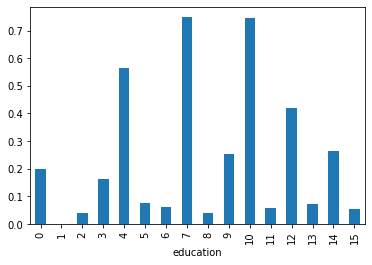

In [20]:
df.groupby('education').income.mean().plot(kind='bar')


<AxesSubplot:xlabel='gender'>

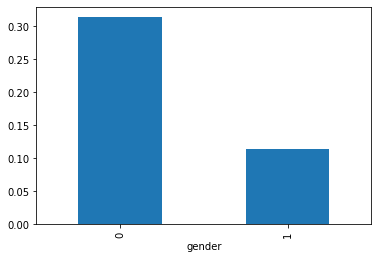

In [21]:
df.groupby('gender').income.mean().plot(kind='bar')


<AxesSubplot:xlabel='race'>

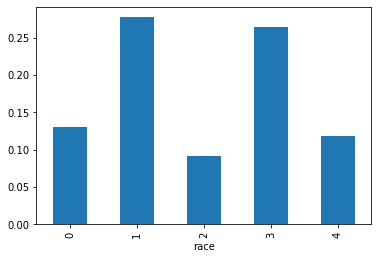

In [22]:
df.groupby('race').income.mean().plot(kind='bar')


<AxesSubplot:xlabel='marital'>

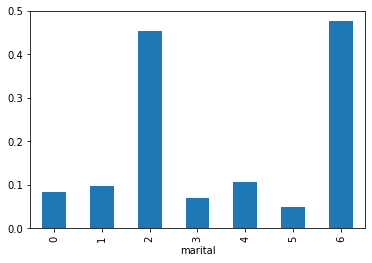

In [23]:
df.groupby('marital').income.mean().plot(kind='bar')


<AxesSubplot:xlabel='workclass'>

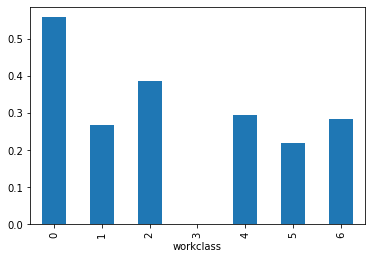

In [24]:
df.groupby('workclass').income.mean().plot(kind='bar')

<AxesSubplot:xlabel='relationship'>

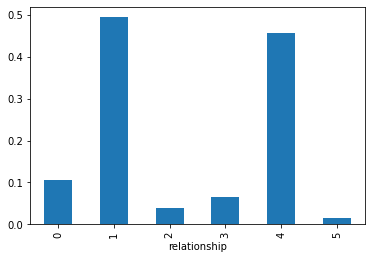

In [25]:
df.groupby('relationship').income.mean().plot(kind='bar')


<AxesSubplot:xlabel='occupation'>

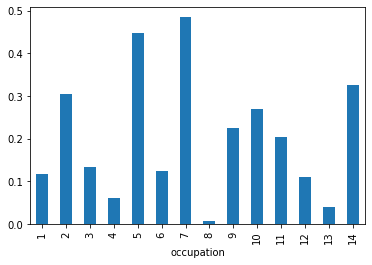

In [26]:
df.groupby('occupation').income.mean().plot(kind='bar')


# Feature Identification

In [27]:
df_x = pd.DataFrame(np.c_[df['relationship'], df['education'], df['race'],df['occupation'],
    df['gender'],df['marital'],df['workclass']], columns = ['relationship','education',
                                                            'race','occupation','gender','marital','workclass'])


In [28]:
df_y = pd.DataFrame(df.income)


# Splitting Data


In [29]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.33)
y_train = y_train.values.flatten()


# Model Selection

As  i need to use 3 diffrent models so, i will do the same one by one first i will select perfect parameter for the model by performing hyperparameter tunig(greed seacrh) then i will get the accuracy.

# 1. RandomForest

In [30]:
para_forest={
 'n_estimators':[60,80,100],
 'criterion': ["gini", "entropy"],
 'max_depth': [None,5 , 10],
 'max_features': ['auto',10,20,30]    
}

In [31]:
grid_rf=GridSearchCV(estimator=RandomForestClassifier(),param_grid=para_forest,cv=3,n_jobs=-1).fit(x_train,y_train)


In [32]:
grid_rf.best_params_


{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 60}

Here i got best parameters for my model now, i will perform training and prediction.

In [33]:
rf=RandomForestClassifier(criterion = 'gini',
 max_depth = 10,
 max_features = 'auto',
 n_estimators = 80)


In [34]:
rf.fit(x_train,y_train)


RandomForestClassifier(max_depth=10, n_estimators=80)

In [35]:
rf_pred=rf.predict(x_test)
rf_pred

array([1, 0, 0, ..., 0, 0, 0])

In [36]:
print(metrics.confusion_matrix(y_test, rf_pred))

[[6972  491]
 [1286 1205]]


In [37]:
print("Accuracy:",metrics.accuracy_score(y_test, rf_pred))

Accuracy: 0.8214788024914608


# 2. Logistic regression

In [38]:
para_reg={'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001,0.01,0.1,1,10,100,1000],
          'fit_intercept': [False,True],
          'verbose': [0,1,2,3],
          'multi_class': ['auto', 'ovr', 'multinomial']
}

In [39]:
grid_reg=GridSearchCV(estimator=LogisticRegression(),param_grid=para_reg,cv=3,n_jobs=-1).fit(x_train,y_train)


In [40]:
grid_reg.best_params_

{'C': 1,
 'fit_intercept': False,
 'multi_class': 'auto',
 'penalty': 'l2',
 'verbose': 0}

In [41]:
reg = LogisticRegression(C = 0.1,
 fit_intercept = False,
 multi_class = 'multinomial',
 penalty = 'l2',
 verbose = 0)

In [42]:
reg.fit(x_train,y_train)


LogisticRegression(C=0.1, fit_intercept=False, multi_class='multinomial')

In [43]:
reg_pred=reg.predict(x_test)

In [44]:
print(metrics.confusion_matrix(y_test, reg_pred))

[[6976  487]
 [1922  569]]


In [45]:
print("Accuracy:",metrics.accuracy_score(y_test, reg_pred))

Accuracy: 0.7579867389993973


# 3. KNeighborsClassifier

In [46]:
p_3={
 'n_neighbors': [1,3,5],  
 'weights': ['uniform','distance'],
   'leaf_size' : [45,70,90]
 }

In [47]:
grid_knn=GridSearchCV(estimator=KNeighborsClassifier(),param_grid=p_3,cv=3,n_jobs=-1).fit(x_train,y_train)

In [48]:
grid_knn.best_params_

{'leaf_size': 70, 'n_neighbors': 5, 'weights': 'uniform'}

In [49]:
knn=KNeighborsClassifier(n_neighbors = 5,  
 weights = 'uniform',
   leaf_size = 70 )

In [50]:
knn.fit(x_train,y_train)

KNeighborsClassifier(leaf_size=70)

In [51]:
knn_pred=knn.predict(x_test)

In [52]:
print(metrics.confusion_matrix(y_test, knn_pred))

[[6673  790]
 [1261 1230]]


In [53]:
print("Accuracy:",metrics.accuracy_score(y_test, knn_pred))

Accuracy: 0.7939521800281294


# Conclusion

After using the 3 different model we are getting accuracy like LogisticRegression < KNeighbors < Random Forest. Hence, Random forest is best for this datset.

# Prediction on unknown data

Now i will use unknow data set as to train my best model and will try to predict.

In [64]:
unknown_data = []
for i in range(len(df.columns)-1):
    unknown_data.append(int(input('Enter value for '+df.columns[i]+' : ')))
    
    
t = rf.predict([unknown_data])



Enter value for workclass : 1
Enter value for education : 7
Enter value for marital : 3
Enter value for occupation : 7
Enter value for relationship : 0
Enter value for race : 2
Enter value for gender : 0


In [65]:
if t == 0:
    print('Income will be equal to or less than 50k')
else:
    print('Income will be more than 50k')

Income will be more than 50k
